In [2]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 58 kB 1.1 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 78 kB 1.5 MB/s            
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=414c5483e28777fc8856a6f933d93748f3b6030de5a77910e0355d9c1a534d92
  Stored in directory: /home/innopolis/.cache/pip/wheels/77/47/e4/44a4ba1b7dfd53faaa35f59f1175e123b213ff401a8a56876b
Successfully built kaggle
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
!~/.local/bin/kaggle competitions download -c cian-datafest-2019

 98%|███████████████████████████████████████▎| 142M/145M [00:02<00:00, 82.9MB/s]
100%|████████████████████████████████████████| 145M/145M [00:02<00:00, 73.3MB/s]


In [7]:
!unzip cian-datafest-2019.zip

Archive:  cian-datafest-2019.zip
  inflating: cian_datafest.zip       
  inflating: test.zip                
  inflating: train.zip               


In [8]:
!mkdir cian-datafest-2019

In [9]:
!mv cian_datafest.zip test.zip train.zip cian-datafest-2019

In [10]:
!ls -lh cian-datafest-2019

total 187M
-rw-rw-r-- 1 innopolis innopolis 95M Dec  3  2019 cian_datafest.zip
-rw-rw-r-- 1 innopolis innopolis 31M Dec  3  2019 test.zip
-rw-rw-r-- 1 innopolis innopolis 62M Dec  3  2019 train.zip


In [11]:
!unzip -q cian-datafest-2019/train.zip -d cian-datafest-2019

In [1]:
from glob import glob

train_images = glob ('cian-datafest-2019/train/*/*.jpg')

In [2]:
train_images[:3], len(train_images)

(['cian-datafest-2019/train/outdoor/45695.jpg',
  'cian-datafest-2019/train/outdoor/63600.jpg',
  'cian-datafest-2019/train/outdoor/51582.jpg'],
 55322)

# Посмотрим, какие ширины и высоты в датасете

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (131072, 131072))

In [5]:
images = [Image.open(path) for path in train_images]
widths = [im.width for im in images]
heights = [im.height for im in images]

(array([2.0000e+00, 6.6000e+01, 3.1200e+02, 2.6400e+03, 1.2720e+03,
        3.3800e+02, 1.3085e+04, 7.2700e+02, 2.0900e+02, 3.6671e+04]),
 array([ 34. ,  40.6,  47.2,  53.8,  60.4,  67. ,  73.6,  80.2,  86.8,
         93.4, 100. ]),
 <BarContainer object of 10 artists>)

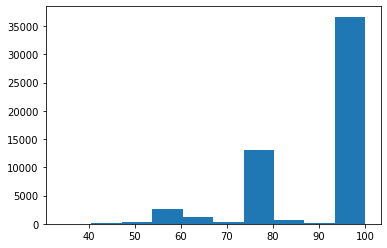

In [19]:
plt.hist(widths)

(array([1.0000e+01, 3.5000e+01, 1.0300e+02, 6.1800e+02, 4.2780e+03,
        1.7820e+03, 1.3281e+04, 1.5577e+04, 2.8900e+02, 1.9349e+04]),
 array([ 14. ,  22.6,  31.2,  39.8,  48.4,  57. ,  65.6,  74.2,  82.8,
         91.4, 100. ]),
 <BarContainer object of 10 artists>)

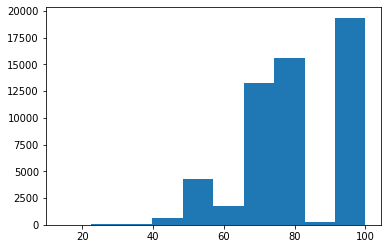

In [20]:
plt.hist(heights)

# Делаем преобразование w, h -> 100, 100

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential

In [8]:
dataset = [im.resize((100, 100), Image.ANTIALIAS) for im in images]

In [9]:
widths = [im.width for im in dataset]
heights = [im.height for im in dataset]

(array([    0.,     0.,     0.,     0.,     0., 55322.,     0.,     0.,
            0.,     0.]),
 array([ 99.5,  99.6,  99.7,  99.8,  99.9, 100. , 100.1, 100.2, 100.3,
        100.4, 100.5]),
 <BarContainer object of 10 artists>)

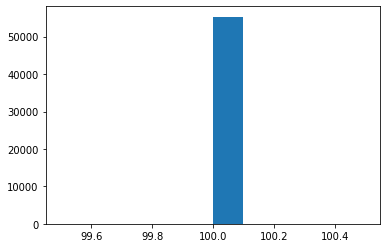

In [15]:
plt.hist(widths)

In [10]:
labeled_dataset = list(zip(dataset, [0 if 'indoor' in path else 1 for path in train_images]))

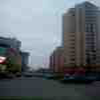

In [12]:
labeled_dataset[0][0]

In [13]:
train, test = train_test_split(labeled_dataset, random_state=42)

In [36]:
X_train = np.array([img_to_array(t[0].convert(mode='RGB')) for t in train])


In [37]:
X_test = np.array([img_to_array(t[0].convert(mode='RGB')) for t in test])


In [38]:
Y_train = np.array([t[1] for t in train]).astype('float64')
Y_test = np.array([t[1] for t in test]).astype('float64')

In [40]:
def create_model():
    model = Sequential()

    model.add(tf.keras.applications.resnet50.ResNet50(input_shape = (100, 100, 3), 
                                  include_top = False, 
                                  weights = 'imagenet'))
    model.add(L.Flatten()) #2048
    model.add(L.Dense(128, activation='relu'))
    model.add(L.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # freeze layers
    for layer in model.layers[0].layers:
        if layer.name == 'conv5_block1_0_conv':
            break
        layer.trainable=False
    return model

In [30]:
X_train[0].shape

(100, 100, 3)

In [32]:
X_train.shape

(41491, 100, 100, 3)

In [41]:
model = create_model()

In [42]:
model.fit(X_train, Y_train,
          batch_size=32, epochs=10,
          verbose=1)

Epoch 1/10
1297/1297 [==============================] - 131s 97ms/step - loss: 0.2592 - accuracy: 0.9199
Epoch 2/10
1297/1297 [==============================] - 127s 98ms/step - loss: 0.1989 - accuracy: 0.9282
Epoch 3/10
1297/1297 [==============================] - 128s 98ms/step - loss: 0.1577 - accuracy: 0.9434
Epoch 4/10
1297/1297 [==============================] - 128s 99ms/step - loss: 0.1273 - accuracy: 0.9556
Epoch 5/10
1297/1297 [==============================] - 128s 98ms/step - loss: 0.1325 - accuracy: 0.9538
Epoch 6/10
1297/1297 [==============================] - 128s 98ms/step - loss: 0.1583 - accuracy: 0.9437
Epoch 7/10
1297/1297 [==============================] - 128s 99ms/step - loss: 0.1689 - accuracy: 0.9405
Epoch 8/10
1297/1297 [==============================] - 128s 98ms/step - loss: 0.1368 - accuracy: 0.9517
Epoch 9/10
1297/1297 [==============================] - 128s 98ms/step - loss: 0.1319 - accuracy: 0.9545
Epoch 10/10
1297/1297 [==============================] 

In [43]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

433/433 [==============================] - 14s 30ms/step - loss: 0.1360 - accuracy: 0.9531
Test score: 0.13604168593883514
Test accuracy: 0.9530764222145081


In [44]:
from sklearn.metrics import roc_auc_score

In [58]:
y_hat = ((model.predict(X_test) > 0.5) + 0.0).astype('int')

In [60]:
Y_test[:5]

array([0., 1., 1., 0., 1.])

In [61]:
roc_auc_score(list(Y_test), list(y_hat))

0.9532742095889852

# Сформируем и отправим решение в kaggle

In [70]:
model.predict(np.expand_dims(X_test[0], axis=0))

array([[0.08281009]], dtype=float32)

In [69]:
np.expand_dims(X_test[0], axis=0).shape

(1, 100, 100, 3)

## Прочитаем и посчитаем тестовый набор. WARNING - вычисления без batch

In [83]:
res=[]

test_images = glob ('cian-datafest-2019/test/*.jpg')

for path in test_images:
    imageid = int(path.split('/')[-1].replace('.jpg',''))
    image = Image.open(path).resize((100, 100), Image.ANTIALIAS).convert(mode='RGB')
    np_image = img_to_array(image)
    
    prob = (model.predict(np.expand_dims(np_image, axis=0)) > 0.5) + 0.0
    res.append([imageid, prob])

In [85]:
len(res)

27660

In [100]:
res1 = [(r[0], int(r[1][0][0])) for r in res]

In [101]:
res1[:3]

[(39031, 0), (52808, 1), (6797, 1)]

In [102]:
import pandas as pd
df = pd.DataFrame(res1,columns=['image_number','prob_outdoor'])

In [103]:
df.to_csv('submission.csv',index=False)

In [88]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [89]:
kaggle = KaggleApi()

In [90]:
kaggle.authenticate()

In [91]:
COMPETITION="cian-datafest-2019"

In [104]:
kaggle.competition_submit("submission.csv", "Resnet50", COMPETITION)

100%|██████████| 212k/212k [00:02<00:00, 85.0kB/s]


Successfully submitted to Классификация изображений

# Получили score 0.95501

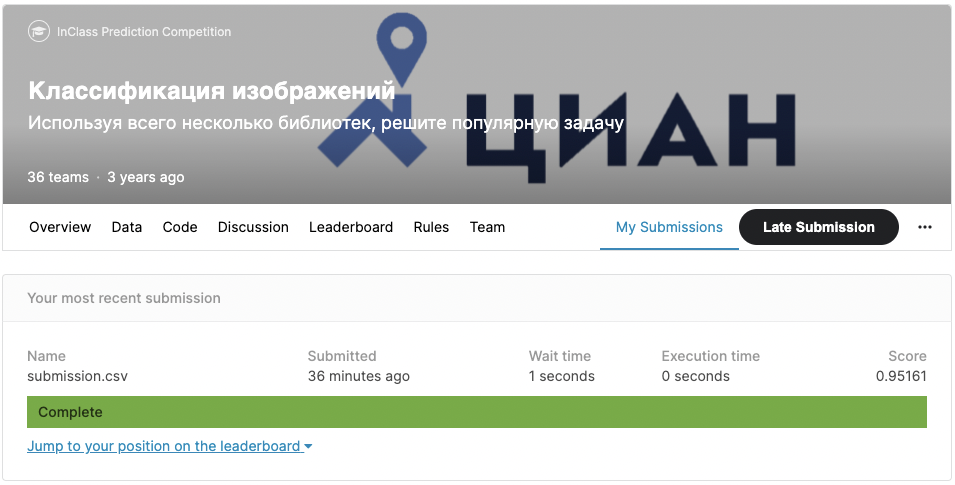